In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model # Import Model for functional API
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [28]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
gender_submission_df = pd.read_csv('gender_submission.csv') # For testing/comparison

In [29]:

# Separate target variable from features for training
X_full = train_df.drop('Survived', axis=1)
y_full = train_df['Survived']


In [30]:

# Identify categorical and numerical features
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex', 'Embarked']


In [31]:

# Create preprocessor
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [32]:

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [33]:

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)


In [34]:

# Apply preprocessing to the full dataset (for autoencoder training)
# Autoencoder training typically uses the full dataset without splitting features from target,
# as it learns features from the input itself.
# We'll fit the preprocessor on X_full and then transform it.
# Note: For the autoencoder, the 'target' is the input itself, not 'Survived'.
X_processed_full = preprocessor.fit_transform(X_full)


In [35]:

# Split the processed data for autoencoder training and validation
X_ae_train, X_ae_val, y_ae_train, y_ae_val = train_test_split(
    X_processed_full, X_processed_full, test_size=0.2, random_state=42
) # y_ae_train/val are also X_processed_full for reconstruction


In [36]:

# Get the number of features after preprocessing for autoencoder input/output
input_dim = X_processed_full.shape[1]
print(f"Number of features after preprocessing: {input_dim}")


Number of features after preprocessing: 12


In [37]:
# --- 2. Build and Train the Autoencoder ---

# Define the Autoencoder architecture
# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer) # First hidden layer
encoded = Dropout(0.2)(encoded) # Added dropout for denoising effect or regularization
encoded = Dense(32, activation='relu')(encoded) # Second hidden layer (bottleneck)
encoded = Dropout(0.2)(encoded)


In [38]:

# Decoder
decoded = Dense(64, activation='relu')(encoded) # Mirrors encoder structure
decoded = Dense(input_dim, activation='linear')(decoded) # Output layer to reconstruct input


In [39]:
# Autoencoder model
autoencoder = Model(input_layer, decoded)


In [40]:

# Compile the Autoencoder (using reconstruction loss)
autoencoder.compile(optimizer='adam', loss='mse') # Mean Squared Error for reconstruction

autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,804 (22.67 KB)

 Trainable params: 5,804 (22.67 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train the Autoencoder
# We use X_ae_train as both input and target for reconstruction
early_stopping_ae = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_ae = autoencoder.fit(X_ae_train, X_ae_train,
                             epochs=100,
                             batch_size=32,
                             shuffle=True,
                             validation_data=(X_ae_val, X_ae_val),
                             callbacks=[early_stopping_ae],
                             verbose=0) # Set verbose to 0 to suppress per-epoch output

print(f"Autoencoder training finished in {len(history_ae.history['loss'])} epochs.")
autoencoder_loss, autoencoder_val_loss = history_ae.history['loss'][-1], history_ae.history['val_loss'][-1]
print(f"Final Autoencoder Training Loss: {autoencoder_loss:.4f}")
print(f"Final Autoencoder Validation Loss: {autoencoder_val_loss:.4f}")


Autoencoder training finished in 62 epochs.
Final Autoencoder Training Loss: 0.0539
Final Autoencoder Validation Loss: 0.0146


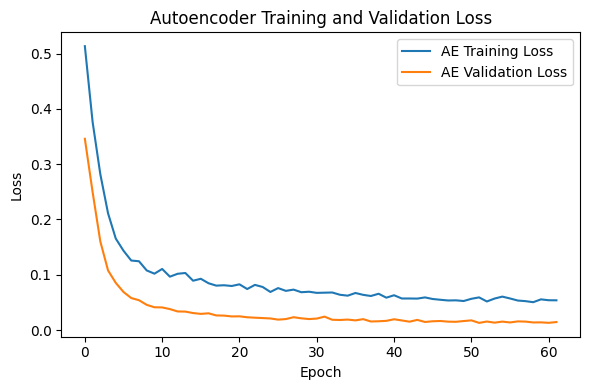

In [42]:
# Plotting autoencoder training history (optional)
plt.figure(figsize=(6, 4))
plt.plot(history_ae.history['loss'], label='AE Training Loss')
plt.plot(history_ae.history['val_loss'], label='AE Validation Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
# --- 3. Build and Train the Classifier (using Autoencoder's encoder) ---

# Extract the encoder part of the Autoencoder
# This assumes 'encoded' is the output of the bottleneck layer
encoder = Model(input_layer, encoded) # This will be the output of the second Dense layer in 'encoded'


In [44]:

# Now, prepare data for classifier training
# X_full and y_full are used here for classifier training
X_clf_train, X_clf_val, y_clf_train, y_clf_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)


In [45]:

# Transform the original features using the preprocessor
X_clf_train_processed = preprocessor.transform(X_clf_train)
X_clf_val_processed = preprocessor.transform(X_clf_val)


In [46]:

# Get the latent representation (encoded features) from the encoder
X_train_encoded = encoder.predict(X_clf_train_processed)
X_val_encoded = encoder.predict(X_clf_val_processed)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [57]:

# Build the classifier model using the encoded features
classifier_input = Input(shape=(X_train_encoded.shape[1],)) # Input shape is the size of the bottleneck
classifier_output = Dense(1, activation='sigmoid')(classifier_input) # Binary classification


In [58]:

classifier_model = Model(classifier_input, classifier_output)


In [59]:

# Compile the classifier
classifier_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

classifier_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Train the Classifier
early_stopping_clf = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_clf = classifier_model.fit(X_train_encoded, y_clf_train,
                                   epochs=100,
                                   batch_size=32,
                                   validation_data=(X_val_encoded, y_clf_val),
                                   callbacks=[early_stopping_clf],
                                   verbose=1)


Epoch 1/100


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3950 - loss: 0.8197 - val_accuracy: 0.3631 - val_loss: 0.7494
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4173 - loss: 0.7900 - val_accuracy: 0.4749 - val_loss: 0.7336
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4792 - loss: 0.7847 - val_accuracy: 0.5475 - val_loss: 0.7201
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5720 - loss: 0.7544 - val_accuracy: 0.5754 - val_loss: 0.7083
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5458 - loss: 0.7393 - val_accuracy: 0.5698 - val_loss: 0.6966
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5680 - loss: 0.7181 - val_accuracy: 0.5754 - val_loss: 0.6854
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6132 - loss: 0.6894 - val_accuracy: 0.5754 - val_loss: 0.6752
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6158 - loss: 0.6827 - val_accuracy: 0.5754 - val_loss: 0.

In [61]:
# --- 4. Evaluate the Classifier Model ---

loss_clf, accuracy_clf = classifier_model.evaluate(X_val_encoded, y_clf_val, verbose=0)
print(f"Classifier Validation Loss: {loss_clf:.4f}")
print(f"Classifier Validation Accuracy: {accuracy_clf:.4f}")


Classifier Validation Loss: 0.4585
Classifier Validation Accuracy: 0.8045


In [62]:

# Make predictions on the validation set
y_pred_proba_clf = classifier_model.predict(X_val_encoded)
y_pred_clf = (y_pred_proba_clf > 0.5).astype(int)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [63]:

print("\nClassification Report (Classifier):")
print(classification_report(y_clf_val, y_pred_clf))

print("\nConfusion Matrix (Classifier):")
print(confusion_matrix(y_clf_val, y_pred_clf))



Classification Report (Classifier):
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       105
           1       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179


Confusion Matrix (Classifier):
[[91 14]
 [21 53]]


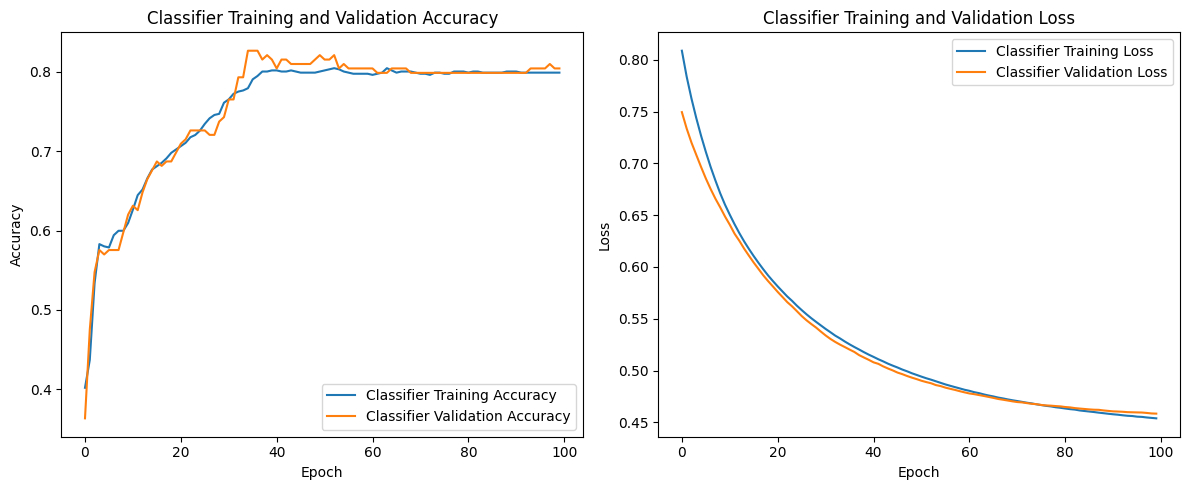

In [64]:

# Plotting classifier training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_clf.history['accuracy'], label='Classifier Training Accuracy')
plt.plot(history_clf.history['val_accuracy'], label='Classifier Validation Accuracy')
plt.title('Classifier Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_clf.history['loss'], label='Classifier Training Loss')
plt.plot(history_clf.history['val_loss'], label='Classifier Validation Loss')
plt.title('Classifier Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [65]:

# --- 5. Make Predictions on Test Data (using Autoencoder and Classifier) ---

# Preprocess the test data
X_test_processed = preprocessor.transform(test_df)


In [66]:

# Get encoded features for the test data using the trained encoder
X_test_encoded = encoder.predict(X_test_processed)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [67]:

# Make final predictions using the trained classifier
y_test_final_pred_proba = classifier_model.predict(X_test_encoded)
y_test_final_pred = (y_test_final_pred_proba > 0.5).astype(int)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [68]:

# Compare with gender_submission.csv for evaluation 
if 'gender_submission_df' in locals():
    y_true_test = gender_submission_df['Survived']
    accuracy_final_test = accuracy_score(y_true_test, y_test_final_pred)
    print(f"\nFinal Test Accuracy (compared to gender_submission.csv): {accuracy_final_test:.4f}")
    print("\nFinal Classification Report on Test Data:")
    print(classification_report(y_true_test, y_test_final_pred))
    print("\nFinal Confusion Matrix on Test Data:")
    print(confusion_matrix(y_true_test, y_test_final_pred))



Final Test Accuracy (compared to gender_submission.csv): 0.9569

Final Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       266
           1       0.94      0.95      0.94       152

    accuracy                           0.96       418
   macro avg       0.95      0.95      0.95       418
weighted avg       0.96      0.96      0.96       418


Final Confusion Matrix on Test Data:
[[256  10]
 [  8 144]]
